In [1]:
''' development / testing only '''

# set auto reload imported modules tagged
%load_ext autoreload
%autoreload 2


In [2]:
''' Import PVLibs Package '''

# add custom python packages directory to path
import sys
sys.path.append('/home/brendan/dev/pvlibs')

# import pvlibs libraries
import pvlibs


ModuleNotFoundError: No module named 'ipyupload'

In [3]:
''' Imports '''

# data array processing
import numpy as np
import pandas as pd

# plotting with matplotlib, inline interactive notebook
%matplotlib notebook
from matplotlib import pyplot as plt


In [16]:
''' Initialise Database and Batch Prepare Files '''

# initialise database instance
db = []

# define source file properties
props = {
    # set file tags (optional)
    'device_state_id': 'init',
    
    # set file parsing (required)
    'meas_type': 'slt',
    'file_type': 'ltr',
    'file_ext': 'ltr',
    
    # set measurement properties (required)
    'wafer_doping_type': 'n-type',
    'temperature': 298.,
    'wafer_resistivity': 1.8,
    'wafer_thickness': .012,
    'wafer_optical_const': 1.03,
    #'illumination_mode': 'gen',
}

# batch prepare source files, recursive search directory and store as nodes in database instance
pvlibs.add_files(db, './test-data/sinton-lifetime/', props)


In [19]:
''' Parse Properties from File Name'''

# define regular expression for parsing measurement properties from file name (device_id and illumination_mode required)
parse_string = '^.+-(?P<device_id>D\d{2})-(?P<illumination_mode>[gen|trans]+)-(?P<wafer_region>\d{2}).*\..+$'

# iterate each node in database
for node in db:
    
    # extract properties from file name
    filename_params = pvlibs.general.str_parse_params(_string = node['file_name'], _parse_string = parse_string)
    
    # if successful, store properties in node
    if filename_params is not None:
        for k,v in filename_params.items():
            node[k] = v

# remove nodes from database if device_id property not found
db = [ d for d in db if 'device_id' in d.keys() ]

# print total nodes (files) prepared
print(len(db))


40


In [20]:
''' Import Sinton-Lifetime Data from File '''

# iterate each node in database
for node in db:
    
    # get data file properties
    meas_type = node['meas_type']
    file_type = node['file_type']
    file_path = node['file_path']
    file_name = node['file_name']
    
    # import data from file and store in node
    data = pvlibs.data_import.core.import_data_file(
        meas_type = meas_type,
        file_type = file_type,
        file_path = file_path,
        file_name = file_name,
    )
    for k,v in data.items():
        node[k] = v


In [21]:
''' Process Sinton-Lifetime Data '''

# iterate each node in database
for node in db:
    
    # get data file properties
    meas_type = node['meas_type']
    
    # process data and store results in node
    results = pvlibs.process_data.core.process_data(
        meas_type = meas_type,
        data = node,
    )
    for k,v in results.items():
        node[k] = v


In [22]:
''' Model Injection Dependent Lifetime Data '''

# iterate each node in database
for node in db:
    
    # set charge density range and model to fit
    node['nd_range'] = [1e14, 1e17]
    node['lt_model'] = 'std'
    
    # run lifetime modelling process, store results in node
    results = pvlibs.process_data.core.process_data(
        meas_type = 'mlt',
        data = node,
    )
    for k,v in results.items():
        node[k] = v


<IPython.core.display.Javascript object>


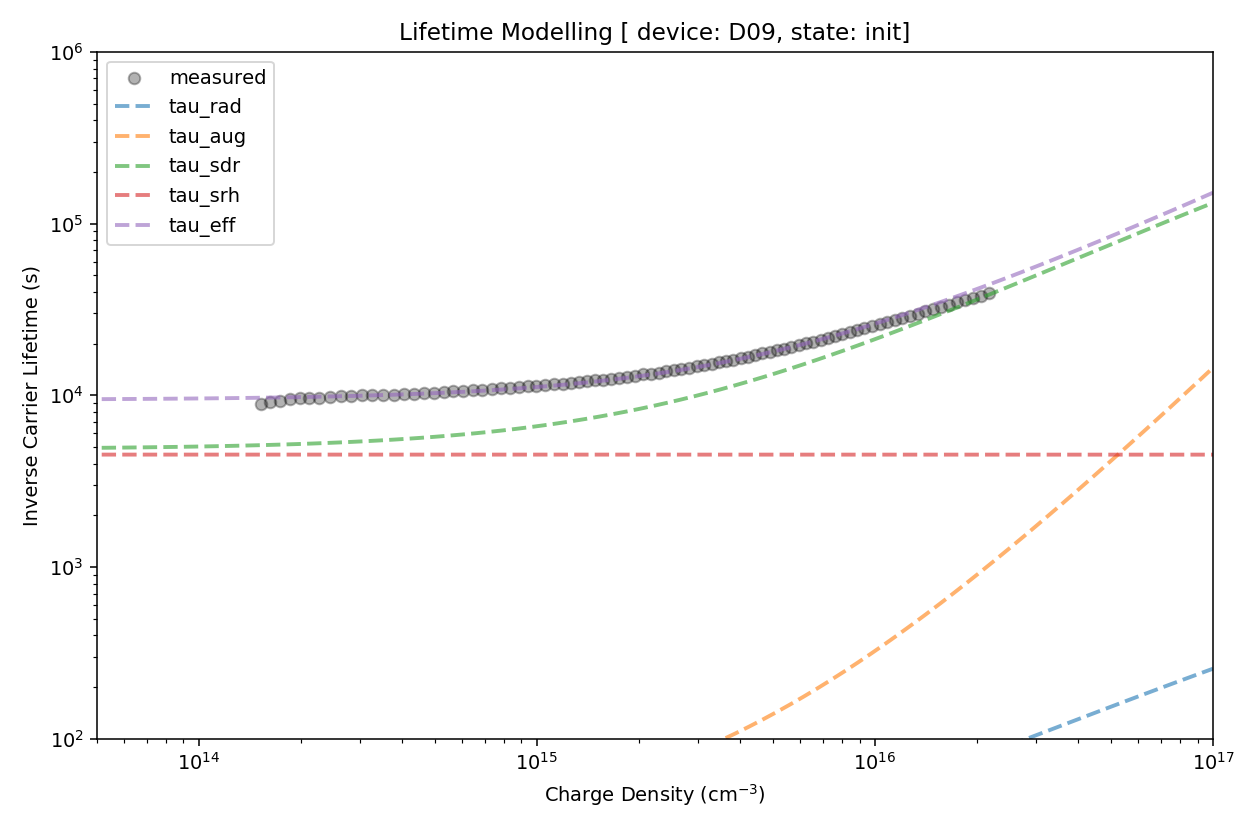

Surface Recombination Velocity (J_0) = 256.1 [fa]
Bulk Lifetime = 221.6 [us]
Effective Lifetime = 100.9 [us]
Implied Voc = 649.7 [V]
Fit R^2 = 1.00


In [23]:
''' Plot Lifetime Modelling Results '''

# set search / filter properties
#device_id = 'XXX'
device_state_id = 'init'

# search for single measurement
_node = [ n for n in db if
    #n['device_id'] == device_id and
    n['device_state_id'] == device_state_id
][0]


# initialise figure and axes
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111)

ax.set_xlim(5e13, 1e17)
ax.set_ylim(1e2, 1e6)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Charge Density (cm$^{-3}$)')
ax.set_ylabel(r'Inverse Carrier Lifetime (s)')

# plot measured charge density dependent effective lifetime
ax.plot(_node['nd'][::3], _node['tau'][::3]**-1, 'ok', label = 'measured', alpha = 0.3)

# iterate and plot each model component
for name, tau in _node.items():
    if name[:4] == 'tau_':
        
        # plot charge density dependent recombination lifetime component
        ax.plot(_node['dn'], tau**-1 , '--', label = '{}'.format(name), linewidth = 2, alpha = 0.6)

# set figure title
ax.set_title('Lifetime Modelling [ device: {}, state: {}]'.format(_node['device_id'], _node['device_state_id']))
        
# display figure
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# print fitting results
print('Surface Recombination Velocity (J_0) = {:.1f} [fa]'.format(_node['J_0']*1e15))
print('Bulk Lifetime = {:.1f} [us]'.format(_node['t_blk']*1e6))
print('Effective Lifetime = {:.1f} [us]'.format(_node['t_eff']*1e6))
print('Implied Voc = {:.1f} [V]'.format(_node['ivoc']*1e3))
print('Fit R^2 = {:.2f}'.format(_node['R2']))


In [24]:
''' Compile Data for Export '''

# set labels and values to export, update names
labels = {'device_id': 'Device', 'device_state_id': 'State', 'wafer_region': 'Region'}
values = {'ivoc': 'iVoc (V)', 'J_0': 'J_0 (A)', 't_blk': 't_Blk (s)', 't_eff': 't_Eff (s)', 'R2': 'R^2', }

## aggregate results from nodes in database
data = {**{ v:[] for k,v in labels.items() }, **{ v:[] for k,v in values.items() } }
for node in db:
    # store labels
    for k,v in labels.items():
        data[v].append( node[k] )
    # store values
    for k,v in values.items():
        data[v].append( node[k] )

# store values in pandas dataframe
data = pd.DataFrame(data)

# display averages
#data.groupby(['State', 'Device', 'Region']).mean()
data.groupby(['State', 'Device']).mean()


iVoc (V)       J_0 (A)  t_Blk (s)  t_Eff (s)       R^2
State Device                                                        
init  D09     0.654976  1.503410e-13   0.000181   0.000107  0.938880
      D19     0.692801  5.353163e-14   0.001540   0.000478  0.569914
      D23     0.704626  2.593938e-14   0.000755   0.000522  0.945280
      D36     0.685421  8.647063e-14   0.101208   0.000541  0.702883
      D45     0.662150  9.006213e-14   0.000222   0.000157  0.842134

In [25]:
''' Export Summary Results '''

# save summary data to csv file
data.to_csv('./sinton-lifetime-batch-summary.csv', index = False)
